# Check uncertainty estimates


[can't start cudnn algorithm](https://stackoverflow.com/questions/53698035/failed-to-get-convolution-algorithm-this-is-probably-because-cudnn-failed-to-in)

In [1]:
# Extensions
%load_ext autoreload 

In [2]:
import os, sys, importlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split


BASE_PATH = os.path.join(os.getcwd(), "..", "..")
MODULE_PATH = os.path.join(BASE_PATH, "modules")
DATASET_PATH = os.path.join(BASE_PATH, "datasets")

sys.path.append(MODULE_PATH)

from bayesian import McDropout, MomentPropagation
import data.mnist as mnist_loader

from data import BenchmarkData, DataSetType
import mp.MomentPropagation as mp

from models.default import default_model
from models.tf_growth import setup_growth

## Prepare Data

In [3]:
benchmark_data = BenchmarkData(DataSetType.MNIST, os.path.join(DATASET_PATH, "mnist"), classes=2)

In [4]:
benchmark_data.targets[:10]

array([0, 1, 1, 1, 1, 0, 1, 1, 0, 0], dtype=uint8)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(benchmark_data.inputs, benchmark_data.targets)

In [6]:
unique_classes = np.unique(benchmark_data.targets)

def print_label_count(targets, unique_labels, prefix="train"):
    print(prefix + "_labels: ")
    
    for label in unique_labels:
        count = (targets==label).sum()
        print("Label-{}: {}".format(label, count))
    
    print("-------------")

print_label_count(y_train, unique_classes)
print_label_count(y_test, unique_classes)

train_labels: 
Label-0: 5155
Label-1: 5930
-------------
train_labels: 
Label-0: 1748
Label-1: 1947
-------------


## Train and build models

In [7]:
setup_growth()

1 Physical GPU's,  1 Logical GPU's


In [8]:
model = default_model()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["binary_accuracy"])

In [9]:
model.fit(x_train, y_train, epochs=100)

Epoch 1/100
347/347 [==============================] - 8s 22ms/step - loss: 0.1320 - binary_accuracy: 0.9920
Epoch 2/100
347/347 [==============================] - 1s 4ms/step - loss: 0.0083 - binary_accuracy: 0.9981
Epoch 3/100
347/347 [==============================] - 1s 4ms/step - loss: 0.0055 - binary_accuracy: 0.9986
Epoch 4/100
347/347 [==============================] - 1s 4ms/step - loss: 0.0091 - binary_accuracy: 0.9980
Epoch 5/100
347/347 [==============================] - 1s 4ms/step - loss: 0.0079 - binary_accuracy: 0.9985
Epoch 6/100
347/347 [==============================] - 1s 4ms/step - loss: 0.0093 - binary_accuracy: 0.9985
Epoch 7/100
347/347 [==============================] - 1s 4ms/step - loss: 0.0031 - binary_accuracy: 0.9992
Epoch 8/100
347/347 [==============================] - 1s 4ms/step - loss: 0.0110 - binary_accuracy: 0.9986
Epoch 9/100
347/347 [==============================] - 1s 4ms/step - loss: 0.0127 - binary_accuracy: 0.9984
Epoch 10/100
347/347 [=====

347/347 [==============================] - 1s 4ms/step - loss: 3.9318e-04 - binary_accuracy: 1.0000
Epoch 75/100
347/347 [==============================] - 1s 4ms/step - loss: 4.3689e-04 - binary_accuracy: 1.0000
Epoch 76/100
347/347 [==============================] - 1s 4ms/step - loss: 0.0098 - binary_accuracy: 0.9995
Epoch 77/100
347/347 [==============================] - 1s 4ms/step - loss: 2.7036e-04 - binary_accuracy: 0.9997
Epoch 78/100
347/347 [==============================] - 1s 4ms/step - loss: 0.0049 - binary_accuracy: 0.9995
Epoch 79/100
347/347 [==============================] - 1s 4ms/step - loss: 0.0093 - binary_accuracy: 0.9996
Epoch 80/100
347/347 [==============================] - 1s 4ms/step - loss: 2.0872e-21 - binary_accuracy: 1.0000
Epoch 81/100
347/347 [==============================] - 1s 4ms/step - loss: 5.6141e-16 - binary_accuracy: 1.0000
Epoch 82/100
347/347 [==============================] - 1s 4ms/step - loss: 0.0048 - binary_accuracy: 0.9994
Epoch 83/100

## Evaluate performance

In [10]:
model.evaluate(x_test, y_test)

116/116 [==============================] - 3s 26ms/step - loss: 0.0069 - binary_accuracy: 0.9992


[0.006884584669023752, 0.9991880655288696]

Predicted label: [[0.]]


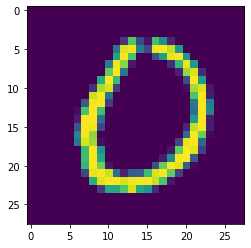

In [11]:
random_indx = np.random.choice(range(len(x_test)))

test_img = x_test[random_indx]
plt.imshow(test_img.reshape((28, 28)))

prediction = model(np.expand_dims(test_img, axis=0))

print("Predicted label: {}".format(prediction))

## Compare regular models

In [33]:
test_inputs = x_test[10:20]
test_targets = y_test[10:20]

test_targets

array([0, 0, 0, 0, 0, 1, 1, 0, 1, 1], dtype=uint8)

In [40]:
pred = []
runs = 100

for i in range(runs):
    pred.append(model(test_inputs, training=True))

pred = np.hstack(pred)

In [41]:
pred.shape

(10, 100)

In [42]:
avg = np.average(pred, axis=1)
avg

array([0., 0., 0., 0., 0., 1., 1., 0., 1., 1.], dtype=float32)

In [43]:
test_mp = mp.MP()
test_mp_model = test_mp.create_MP_Model(model=model, use_mp=False, verbose=False)

In [50]:
results = test_mp_model(test_inputs)
results

[<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
 array([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.]], dtype=float32)>,
 <tf.Tensor: shape=(10, 1), dtype=float32, numpy=
 array([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], dtype=float32)>]

# Compare metrics

In [12]:
%autoreload 2
dp_model = McDropout(model)
mp_model = MomentPropagation(model)

In [14]:
values = dp_model.predict(test_inputs)

In [31]:
# mc dropout max_entropy
mc_max_entropy = dp_model.get_query_fn("max_entropy")(x_test[10:50], runs=10)
mc_max_entropy

[[-0.69114918 -0.69114918]
 [-1.60445037 -0.22189433]
 [-0.50916034 -0.91379385]
 [-0.35524739 -1.20064501]
 [-0.69114918 -0.69114918]
 [-1.3108708  -0.31140826]
 [-0.50916034 -0.91379385]
 [-0.35524739 -1.20064501]
 [-0.69114918 -0.69114918]
 [-1.20064501 -0.35524739]
 [-0.50916034 -0.91379385]
 [-0.35524739 -1.20064501]
 [-0.69114918 -0.69114918]
 [-1.3108708  -0.31140826]
 [-0.50916034 -0.91379385]
 [-0.35524739 -1.20064501]
 [-0.69114918 -0.69114918]
 [-1.60445037 -0.22189433]
 [-0.50916034 -0.91379385]
 [-0.35524739 -1.20064501]
 [-0.69114918 -0.69114918]
 [-1.3108708  -0.31140826]
 [-0.50916034 -0.91379385]
 [-0.35524739 -1.20064501]
 [-0.69114918 -0.69114918]
 [-1.3108708  -0.31140826]
 [-0.50916034 -0.91379385]
 [-0.35524739 -1.20064501]
 [-0.69114918 -0.69114918]
 [-1.5949702  -0.22428742]
 [-0.50916034 -0.91379385]
 [-0.35524739 -1.20064501]
 [-0.69114918 -0.69114918]
 [-1.20064501 -0.35524739]
 [-0.50916034 -0.91379385]
 [-0.35524739 -1.20064501]
 [-0.69114918 -0.69114918]
 

array([0.69114918, 0.49840554, 0.67101375, 0.60886668, 0.69114918,
       0.5798491 , 0.67101375, 0.60886668, 0.69114918, 0.60886668,
       0.67101375, 0.60886668, 0.69114918, 0.5798491 , 0.67101375,
       0.60886668, 0.69114918, 0.49840554, 0.67101375, 0.60886668,
       0.69114918, 0.5798491 , 0.67101375, 0.60886668, 0.69114918,
       0.5798491 , 0.67101375, 0.60886668, 0.69114918, 0.50104825,
       0.67101375, 0.60886668, 0.69114918, 0.60886668, 0.67101375,
       0.60886668, 0.69114918, 0.49840554, 0.67101375, 0.60886668])

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)>

In [37]:
# moment propagation max entropy
%autoreload 2
mp_max_entropy = mp_model.get_query_fn("max_entropy")(x_test[:90])
mp_max_entropy

array([-7.908756 , -7.908756 , -7.908756 , -7.908756 , -7.908756 ,
       -7.908756 , -7.908756 , -7.908756 , -7.908756 , -7.908756 ,
       -7.908756 , -7.908756 , -7.908756 , -7.908756 , -7.908756 ,
       -7.908756 , -7.908756 , -7.908756 , -7.908756 , -7.908756 ,
       -2.5323493, -7.908756 , -7.908756 , -7.908756 , -7.908756 ,
       -7.908756 , -7.908756 , -7.908756 , -7.908756 , -7.908756 ,
       -7.908756 , -7.908756 , -7.908756 , -7.908756 , -7.908756 ,
       -7.908756 , -7.908756 , -7.908756 , -7.908756 , -7.908756 ,
       -7.908756 , -7.908756 , -7.908756 , -7.908756 , -7.908756 ,
       -7.908756 , -7.908756 , -7.908756 , -7.908756 , -7.908756 ,
       -7.908756 , -7.908756 , -7.908756 , -7.908756 , -7.908756 ,
       -7.908756 , -7.908756 , -7.908756 , -7.908756 , -7.908756 ,
       -7.908756 , -7.908756 , -7.908756 , -7.908756 , -7.908756 ,
       -7.908756 , -7.908756 , -7.908756 , -7.908756 , -7.908756 ,
       -7.908756 , -7.908756 , -7.908756 , -7.908756 , -7.9087